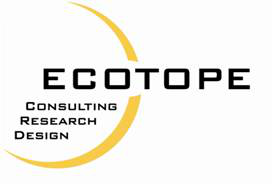

In [1]:
from IPython.display import Image
#Image(filename='ecotope_color_logo.png') 
Image(filename = "ecotope_color_logo.png", width=251.8, height=55.5)

In [2]:
import pandas as pd
import numpy as np

import math
import sqlite3
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## FILE PATH
# define path for database file, you will have to edit to your repository path or it will NOT work
path = "C:\\Users\\scott\\github\\OCCE_HVAC_Comparison\\"
filename = "NEAA_final_dataset.db"

# make connection
con = sqlite3.connect(os.path.join(path, filename))

In [4]:
coolingEst_droplist=[22,24]
#coolingEst_droplist=[1,6,7,8,9,10,11,12,20,22,24,25,26,31,32,43]
#len(coolingEst_droplist)

# Calculate Building Square Footages - Heated and Cooled

In [5]:
# query sql spaces
sql_query = 'SELECT siteid, spaceconditioning, totalmeasurement FROM SPACES'

AREAS = pd.read_sql_query(sql_query, con)
AREAS = AREAS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

# groupby two columns
AREAS = AREAS.groupby(by=['siteid','spaceconditioning']).sum()
# flip
AREAS = AREAS.unstack()
AREAS = AREAS.replace(np.nan, 0, regex=True) #replace blank spaces with NaN

# sum rows
AREAS['Total Heated Area']=AREAS['totalmeasurement']['Heated Only']+AREAS['totalmeasurement']['Heated and Cooled']
AREAS['Total Cooled Area']=AREAS['totalmeasurement']['Cooled Only']+AREAS['totalmeasurement']['Heated and Cooled']

#check
AREAS = AREAS.replace(0, np.nan, regex=True) #replace blank spaces with NaN

# to csv
folder = 'RESULTS\\'
name = 'AREAS.csv'
AREAS.to_csv(path + folder + name)

In [6]:
#reset areas entered incorrectle
AREAS.loc[AREAS.index==105795,'Total Cooled Area']=(54691+6711)
AREAS.loc[AREAS.index==108855,'Total Cooled Area']=52096
AREAS.loc[AREAS.index==109236,'Total Cooled Area']=50026
AREAS.loc[AREAS.index==100201,'Total Cooled Area']=87500
AREAS.loc[AREAS.index==101959,'Total Cooled Area']=140598
AREAS.loc[AREAS.index==103148,'Total Cooled Area']=71918
AREAS.loc[AREAS.index==104111,'Total Cooled Area']=28476
AREAS.loc[AREAS.index==105459,'Total Cooled Area']=174601
AREAS.loc[AREAS.index==104148,'Total Cooled Area']=45791
AREAS.loc[AREAS.index==104916,'Total Cooled Area']=14114
AREAS.loc[AREAS.index==105601,'Total Cooled Area']=29400
AREAS.loc[AREAS.index==106207,'Total Cooled Area']=243000
AREAS.loc[AREAS.index==107666,'Total Cooled Area']=98000
AREAS.loc[AREAS.index==110564,'Total Cooled Area']=33125
AREAS.loc[AREAS.index==110719,'Total Cooled Area']=32953
AREAS.loc[AREAS.index==112551,'Total Cooled Area']=403566
AREAS.loc[AREAS.index==113650,'Total Cooled Area']=29581
AREAS.loc[AREAS.index==103453,'Total Cooled Area']=164179

In [7]:
cooled_area = AREAS.reset_index()['Total Cooled Area']
heated_area = AREAS.reset_index()['Total Heated Area']

# OUTDOOR AIR LOAD

In [8]:
# Inputs
t_oa_winter = {'Portland':25.0, 'Albany':24.8, 'Eugene':22.8, 'Bend':5.2, 'Salem':23.7,
               'Stayton':23.7, 'Beaverton':25.0, 'Newberg':25.0, 'Medford':22.8, 'Tualatin':25.0,
               'Sherwood':25.0, 'Corvallis':24.8, 'Helix':8.2, 'Crescent':5.2} # outdoor air temperature at Heating Design Setpoint

t_oa_summer = {'Portland':91.2, 'Albany':92.7, 'Eugene':91.8, 'Bend':93.2, 'Salem':92.1,
               'Stayton':92.1, 'Beaverton':91.2, 'Newberg':91.2, 'Medford':99.0, 'Tualatin':91.2,
               'Sherwood':91.2, 'Corvallis':92.7, 'Helix':96.8, 'Crescent':93.2} # outdoor air temperature at Heating Design Setpoint

t_stpt = 72 # room setpoint temperatures

# df rows to print
row = 5

In [9]:
## cfm/sf calculation

# text for OA sql query
sql_query = "SELECT SPACES.siteid, SITE_DETAILS.city, SPACES.[cfm/sf], SPACES.totalmeasurement, SPACES.conditionedmeasurement " #
sql_query += "FROM SPACES "
sql_query += "LEFT JOIN SITE_DETAILS "
sql_query += "ON SPACES.siteid = SITE_DETAILS.siteid"

OA_LOADS = pd.read_sql_query(sql_query, con)
OA_LOADS = OA_LOADS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

# estimate outdoor air
OA_LOADS['OutdoorAir [cfm]'] = (OA_LOADS['cfm/sf'] * OA_LOADS['totalmeasurement'])

# calculate heating load from OA
cooling = []
heating = []
for i in range(0,len(OA_LOADS)):
    cooling.append((1.08 * OA_LOADS['OutdoorAir [cfm]'][i] * (t_oa_summer[OA_LOADS['city'][i]] - t_stpt)) / 1000)
    heating.append((1.08 * OA_LOADS['OutdoorAir [cfm]'][i] * (t_stpt - t_oa_winter[OA_LOADS['city'][i]])) / 1000)
    
# append lists to df
OA_LOADS['OA Heating Load [kBtu]'] = heating
OA_LOADS['OA Cooling Load [kBtu]'] = cooling

OA_LOADS = OA_LOADS.groupby('siteid').sum()

In [10]:
## Outdoor Air Loads / Area

OA_LOADS['Overall cfm/sf'] = OA_LOADS['OutdoorAir [cfm]']/OA_LOADS['totalmeasurement']
OA_LOADS['OA Heating [sf / kBtu]'] = AREAS['Total Heated Area'] / OA_LOADS['OA Heating Load [kBtu]']
OA_LOADS['OA Cooling [sf / ton]'] = AREAS['Total Cooled Area'] / (OA_LOADS['OA Cooling Load [kBtu]'] / 12)

In [11]:
folder = 'RESULTS\\'
name = 'OA_LOADS.csv'
OA_LOADS.to_csv(path + folder + name)

## [CFM/SF] Loads

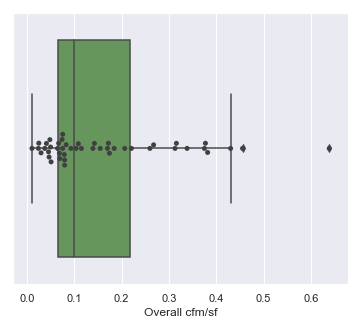

In [12]:
sns.set(rc={'figure.figsize':(6,5)})
ax = sns.swarmplot(x=OA_LOADS['Overall cfm/sf'], color=".25")
ax = sns.boxplot(x=OA_LOADS['Overall cfm/sf'], color=sns.xkcd_rgb["muted green"])

## Outdoor Air Heating Loads

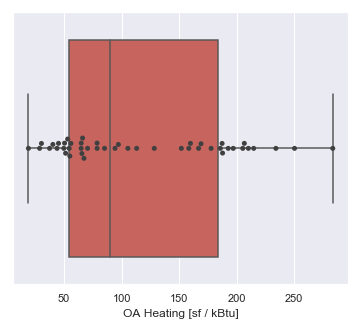

In [13]:
ax = sns.swarmplot(x=OA_LOADS['OA Heating [sf / kBtu]'], color=".25")
ax = sns.boxplot(x=OA_LOADS['OA Heating [sf / kBtu]'], color=sns.xkcd_rgb["pale red"])

## Outdoor Air Cooling Loads

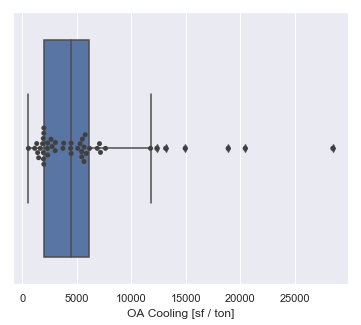

In [14]:
ax = sns.swarmplot(x=OA_LOADS['OA Cooling [sf / ton]'], color=".25")
ax = sns.boxplot(x=OA_LOADS['OA Cooling [sf / ton]'])

# COOLING LOAD

In [15]:
## VARIABLES DEFINED
# Design Day temperature by city
t_oa_winter = {'Portland':25.0, 'Albany':24.8, 'Eugene':22.8, 'Bend':5.2, 'Salem':23.7,
               'Stayton':23.7, 'Beaverton':25.0, 'Newberg':25.0, 'Medford':22.8, 'Tualatin':25.0,
               'Sherwood':25.0, 'Corvallis':24.8, 'Helix':8.2, 'Crescent':5.2} # outdoor air temperature at Heating Design Setpoint
t_oa_summer = {'Portland':91.2, 'Albany':92.7, 'Eugene':91.8, 'Bend':93.2, 'Salem':92.1,
               'Stayton':92.1, 'Beaverton':91.2, 'Newberg':91.2, 'Medford':99.0, 'Tualatin':91.2,
               'Sherwood':91.2, 'Corvallis':92.7, 'Helix':96.8, 'Crescent':93.2} # outdoor air temperature at Heating Design Setpoint
t_stpt = 72 # room setpoint temperatures

# variables used in CLTD conduction/convection heat gain
cltd_start=40 # starting assumed CLTD for walls and roof
k=1
f=1

# varaibles used for CLF solar heat gain

clfN = 0.82 # cooling load factor, table 13 ashrae 1985
shgfN = 33 # max solar heat gain factor, table 11 ashrae 1985

clfS = 0.65 # cooling load factor, table 13 ashrae 1985
shgfS = 180 # max solar heat gain factor, table 11 ashrae 1985

clfE = 0.32 # cooling load factor, table 13 ashrae 1985
shgfE = 211 # max solar heat gain factor, table 11 ashrae 1985

clfW = 0.32 # cooling load factor, table 13 ashrae 1985
shgfW = 211 # max solar heat gain factor, table 11 ashrae 1985

# rows to show
row = 15

In [16]:
## QUERY
# text for UA sql query
sql_query = 'SELECT SITE_DETAILS.siteid, SITE_DETAILS.totalconditionedfloorareaofallbuildings, SITE_DETAILS.totalgrossfloorareaofallbuildings, '
sql_query += 'SITE_DETAILS.[detail.primarybuildingtypecategory], SITE_DETAILS.city, OVERALL_UA.[ua.total], '
sql_query += 'COOLINGLOADENV.WallNorth, COOLINGLOADENV.WallSouth, COOLINGLOADENV.WallEast, COOLINGLOADENV.WallWest, '
sql_query += 'COOLINGLOADENV.WindowNorth, COOLINGLOADENV.WindowSouth, COOLINGLOADENV.WindowEast, COOLINGLOADENV.WindowWest, '
sql_query += 'COOLINGLOADENV.SC, COOLINGLOADENV.LPD, COOLINGLOADENV.EPD, COOLINGLOADENV.PPL '
sql_query += 'FROM SITE_DETAILS '
sql_query += 'LEFT JOIN OVERALL_UA '
sql_query += 'ON SITE_DETAILS.siteid = OVERALL_UA.siteid '
sql_query += 'LEFT JOIN COOLINGLOADENV '
sql_query += 'ON SITE_DETAILS.siteid = COOLINGLOADENV.siteid'

ENV_GAIN = pd.read_sql_query(sql_query, con)
ENV_GAIN = ENV_GAIN.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

#ENV_GAIN.head(row)

In [17]:
## ENVELOPE GAIN - CONDUCTION AND CONVECTION

# CLTD adjustments
# Calculate weighted wall LM
lmN = 3
lmE = 1
lmS = 7
lmW = 1

uaGain = []

for i in range(0, len(ENV_GAIN)):
    uaGain.append((ENV_GAIN['ua.total'][i]*(t_oa_summer[ENV_GAIN['city'][i]])-t_stpt) / 12000) # /1000 for kBtu

# calculate heat gain from conduction
ENV_GAIN['Heat Gain UA [kBtu]'] = uaGain

## EVELOPE GAIN FENESTRATION

solarGain_list = []
for i in range(0, len(ENV_GAIN)):
    solarGainNorth = (ENV_GAIN['WindowNorth'][i]*ENV_GAIN['SC'][i]*shgfN*clfN) / 1000
    solarGainSouth = (ENV_GAIN['WindowSouth'][i]*ENV_GAIN['SC'][i]*shgfS*clfS) / 1000
    solarGainEast = (ENV_GAIN['WindowEast'][i]*ENV_GAIN['SC'][i]*shgfE*clfE) / 1000
    solarGainWest = (ENV_GAIN['WindowWest'][i]*ENV_GAIN['SC'][i]*shgfW*clfW) / 1000
    
    solarGain = solarGainNorth+solarGainSouth+solarGainEast+solarGainWest
    solarGain_list.append(solarGain)
    
ENV_GAIN['Heat Gain Solar [kBtu]'] = solarGain_list

## INTERNAL LOADS

internalGains = []
for i in range(0, len(ENV_GAIN)):
    
    # determine area to use
    if math.isnan(ENV_GAIN['totalconditionedfloorareaofallbuildings'][i]):
        if math.isnan(ENV_GAIN['totalgrossfloorareaofallbuildings'][i]):
            area = 0
        else:
            area = ENV_GAIN['totalgrossfloorareaofallbuildings'][i]
    else:
        area = ENV_GAIN['totalconditionedfloorareaofallbuildings'][i]
    
    # check internal load assumptions ** dividing by 10 to make reasonable. 
    internalGains.append((area * (ENV_GAIN['LPD'][i] + ENV_GAIN['EPD'][i] + ENV_GAIN['PPL'][i])) / 1000)

ENV_GAIN['Heat Gain Internal [kBtu]'] = internalGains

## SUMMATION

ENV_GAIN['Cooling Load - Envelop and Internal [kBtu]'] = ENV_GAIN['Heat Gain Solar [kBtu]'] + ENV_GAIN['Heat Gain UA [kBtu]'] + ENV_GAIN['Heat Gain Internal [kBtu]']

# Estimated kBtu / sf
ENV_GAIN['Cooling [kBtu / sf]'] = ENV_GAIN['Cooling Load - Envelop and Internal [kBtu]'] / cooled_area
ENV_GAIN['Cooling [sf / ton]'] = cooled_area / (ENV_GAIN['Cooling Load - Envelop and Internal [kBtu]'] / 12)

## CSV EXPORT
folder = 'RESULTS\\'
name = 'ENV_GAIN.csv'
ENV_GAIN.to_csv(path + folder + name)

## Calclulated Cooling Load vs Building Type - Envelope and Internal Loads

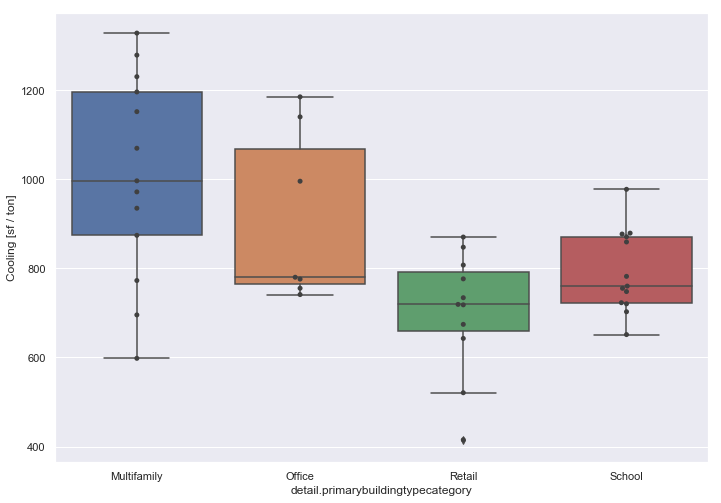

In [18]:
ENV_GAIN_plot = ENV_GAIN.drop(coolingEst_droplist)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y="Cooling [sf / ton]", data=ENV_GAIN_plot, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y="Cooling [sf / ton]", data=ENV_GAIN_plot)

# HEATING LOAD 

In [19]:
# text for UA sql query
sql_query = 'SELECT SITE_DETAILS.siteid, SITE_DETAILS.totalconditionedfloorareaofallbuildings, SITE_DETAILS.totalgrossfloorareaofallbuildings, '
sql_query += 'SITE_DETAILS.[detail.primarybuildingtypecategory], SITE_DETAILS.city, '
sql_query += 'OVERALL_UA.[ua.total]FROM SITE_DETAILS LEFT JOIN OVERALL_UA '
sql_query += 'ON SITE_DETAILS.siteid = OVERALL_UA.siteid'

ENV_LOSS = pd.read_sql_query(sql_query, con)
ENV_LOSS = ENV_LOSS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN.

In [20]:
env_loss = []

# Envelope Loss Calculation
for i in range(0,len(ENV_LOSS)):
    1
    env_loss.append((ENV_LOSS['ua.total'][i]*(t_stpt - t_oa_winter[ENV_LOSS['city'][i]])) / 1000) # /1000 for kBtu
    
ENV_LOSS['Heating Load - Envelope [kBtu]'] = env_loss

In [21]:
## SF PER kBtu CHECK

# Estimated kBtu / sf
ENV_LOSS['Heating [sf / kBtu]'] = heated_area / ENV_LOSS['Heating Load - Envelope [kBtu]']

## Calclulated Heating Load vs Building Type - Envelope Load

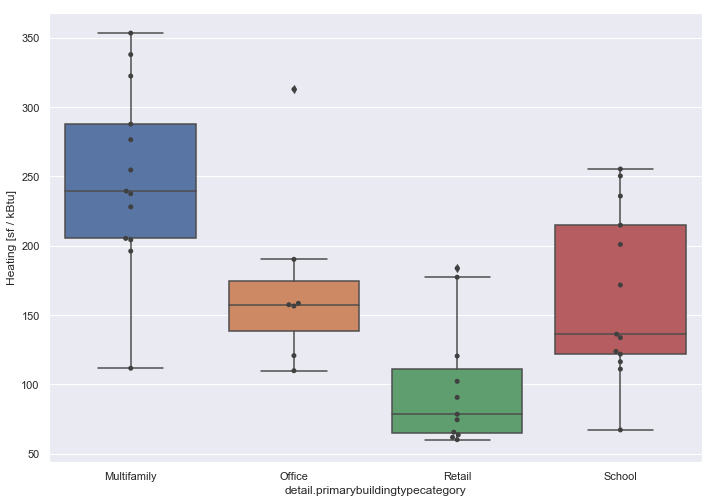

In [22]:
ENV_LOSS_plot=ENV_LOSS.drop(coolingEst_droplist)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y="Heating [sf / kBtu]", data=ENV_LOSS_plot, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y="Heating [sf / kBtu]", data=ENV_LOSS_plot)

# EQUIPMENT CAPACITIES

In [23]:
# Dictionaries used to support calculations

# Chillers and boiler carrier load in hydronic equipment, not the equipment themselves
# to avoid double counting, this dictionary is used as a multiplier
sources = {'None':0, 'Natural Gas':1, 'Hot Water':0, 'Electricity':1, 'Heat Pump or RCC':1, 
           'Condenser Water':0, 'Propane':1, 'Chilled Water':0, 'Chilled and Hot Water (cool/heat)':0}
# conversions to kBtu
conver = {'kBtu':1, 'mBh':1, 'kW':3.41, 'Btu':0.01, 'watts': 0.0341, 'tons':12, 'None':0, np.nan:0}

### AHUS

In [24]:
## AHUs
sql_query = 'SELECT siteid, hvaczoneid, qty, equiptype, heatingoutputcapacity, heatingoutputcapacityunits, heatingsource, coolingoutputcapacity, coolingoutputcapacityunits, coolingsource FROM AHUS'
AHUS = pd.read_sql_query(sql_query, con)
AHUS = AHUS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

heatSourceCounter = 0
coolSourceCounter = 0

adjustedHeatingCap = []
adjustedCoolingCap = []

n = 0

for i in range(0, len(AHUS)):
    # conversions to kBtu * sources dictionary elimates double counting * capacity * quantity
    adjustedHeatingCap.append(conver[AHUS['heatingoutputcapacityunits'][i]] * sources[AHUS['heatingsource'][i]] 
                              * AHUS['heatingoutputcapacity'][i] * AHUS['qty'][i])
    adjustedCoolingCap.append(conver[AHUS['coolingoutputcapacityunits'][i]] * sources[AHUS['coolingsource'][i]] 
                              * AHUS['coolingoutputcapacity'][i] * AHUS['qty'][i])
    
    n = n+1
    #print(n)
    
AHUS['totalHeatingCapacity [kBtu]'] = adjustedHeatingCap
AHUS['totalCoolingCapacity [kBtu]'] = adjustedCoolingCap

#AHUS.head()

### BOILERS

In [25]:
## BOILERS
sql_query = 'SELECT siteid, hvaczoneid, qty, outputcapacity, capacityunits FROM BOILERS'
BOILERS = pd.read_sql_query(sql_query, con)

adjustedHeatingCap = []
for i in range(0, len(BOILERS)):
    adjustedHeatingCap.append(BOILERS['qty'][i] * BOILERS['outputcapacity'][i])
    
BOILERS['totalHeatingCapacity [kBtu]'] = adjustedHeatingCap
#BOILERS.head(row)

### CHILLERS

In [26]:
## CHILLERS
sql_query = 'SELECT siteid, hvaczoneid, qty, capacity, capacityunits FROM CHILLERS'
CHILLERS = pd.read_sql_query(sql_query, con)

adjustedCoolingCap = []
for i in range(0, len(CHILLERS)):
    adjustedCoolingCap.append(CHILLERS['qty'][i] * CHILLERS['capacity'][i])

CHILLERS['totalCoolingCapacity [kBtu]'] = adjustedCoolingCap

#CHILLERS.head(row)

### HPSACS

In [27]:
# HPSACS

sql_query = 'SELECT siteid, hvaczoneid, qty, heatingoutputcapacity, heatingoutputcapacityunits, coolingoutputcapacity, coolingoutputcapacityunits FROM HPSACS'
HPSACS = pd.read_sql_query(sql_query, con)

adjustedHeatingCap = []
adjustedCoolingCap = []

for i in range(0, len(HPSACS)):
    adjustedHeatingCap.append(HPSACS['qty'][i] * HPSACS['heatingoutputcapacity'][i])
    adjustedCoolingCap.append(HPSACS['qty'][i] * HPSACS['coolingoutputcapacity'][i])

HPSACS['totalHeatingCapacity [kBtu]'] = adjustedHeatingCap
HPSACS['totalCoolingCapacity [kBtu]'] = adjustedCoolingCap
    
#HPSACS.head(row)

### TERMINAL UNITS

In [28]:
sql_query = 'SELECT siteid, hvaczoneid, qty, fuel, heatingcapacity, heatingcapacityunits, coolingcapacity, coolingcapacityunits FROM TERMINALUNITS'
TERMINALUNITS = pd.read_sql_query(sql_query, con)
TERMINALUNITS = TERMINALUNITS.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

adjustedHeatingCap = []
adjustedCoolingCap = []

for i in range(0, len(TERMINALUNITS)):
    # convert units * sources dictionary elimates double counting * capacity * quantity
    adjustedHeatingCap.append(conver[TERMINALUNITS['heatingcapacityunits'][i]] * sources[TERMINALUNITS['fuel'][i]]
                              * TERMINALUNITS['qty'][i] * TERMINALUNITS['heatingcapacity'][i])      
    adjustedCoolingCap.append(conver[TERMINALUNITS['coolingcapacityunits'][i]] * sources[TERMINALUNITS['fuel'][i]]
                              * TERMINALUNITS['qty'][i] * TERMINALUNITS['coolingcapacity'][i])
        
TERMINALUNITS['totalHeatingCapacity [kBtu]'] = adjustedHeatingCap
TERMINALUNITS['totalCoolingCapacity [kBtu]'] = adjustedCoolingCap

#TERMINALUNITS.head(row)

In [29]:
## CREATE SUMMATION DATAFRAME - CAPACITIES

# Goupby Sites
# this step makes all dfs siteid indexed
AHUS = AHUS.groupby('siteid').sum()
BOILERS = BOILERS.groupby('siteid').sum()
CHILLERS = CHILLERS.groupby('siteid').sum()
HPSACS = HPSACS.groupby('siteid').sum()
TERMINALUNITS = TERMINALUNITS.groupby('siteid').sum()

In [30]:
# Create DataFrame of Sites

# text for UA sql query
sql_query = 'SELECT SITE_DETAILS.totalconditionedfloorareaofallbuildings, '
sql_query += 'SITE_DETAILS.totalgrossfloorareaofallbuildings, ' 
sql_query += 'siteid, stratum, city, SITE_DETAILS.[detail.primarybuildingtypecategory] FROM SITE_DETAILS'

CAPACITIES = pd.read_sql_query(sql_query, con)
CAPACITIES = CAPACITIES.replace(r'^\s*$', np.nan, regex=True) #replace blank spaces with NaN

In [31]:
# Map to dictionaries to add to dataframes

# AHUS
ahu_heating = dict(zip(AHUS.index.tolist(),AHUS['totalHeatingCapacity [kBtu]'].tolist()))
ahu_cooling = dict(zip(AHUS.index.tolist(),AHUS['totalCoolingCapacity [kBtu]'].tolist()))
CAPACITIES['AHUS_heating [kBtu]'] = CAPACITIES['siteid'].map(ahu_heating)
CAPACITIES['AHUS_cooling [kBtu]'] = CAPACITIES['siteid'].map(ahu_cooling)

# BOILERS
boiler_heating = dict(zip(BOILERS.index.tolist(),BOILERS['totalHeatingCapacity [kBtu]'].tolist()))
CAPACITIES['BOILERS_heating [kBtu]'] = CAPACITIES['siteid'].map(boiler_heating)

# CHILLERS
chiller_cooling = dict(zip(CHILLERS.index.tolist(),CHILLERS['totalCoolingCapacity [kBtu]'].tolist()))
CAPACITIES['CHILLERS_cooling [kBtu]'] = CAPACITIES['siteid'].map(chiller_cooling)

# HPSACS
HP_heating = dict(zip(HPSACS.index.tolist(),HPSACS['totalHeatingCapacity [kBtu]'].tolist()))
HP_cooling = dict(zip(HPSACS.index.tolist(),HPSACS['totalCoolingCapacity [kBtu]'].tolist()))
CAPACITIES['HPSACS_heating [kBtu]'] = CAPACITIES['siteid'].map(HP_heating)
CAPACITIES['HPSACS_cooling [kBtu]'] = CAPACITIES['siteid'].map(HP_cooling)

# TERMINALUNITS
TERM_heating = dict(zip(TERMINALUNITS.index.tolist(),TERMINALUNITS['totalHeatingCapacity [kBtu]'].tolist()))
TERM_cooling = dict(zip(TERMINALUNITS.index.tolist(),TERMINALUNITS['totalCoolingCapacity [kBtu]'].tolist()))
CAPACITIES['TERMINALUNITS_heating [kBtu]'] = CAPACITIES['siteid'].map(TERM_heating)
CAPACITIES['TERMINALUNITS_cooling [kBtu]'] = CAPACITIES['siteid'].map(TERM_cooling)

In [32]:
CAPACITIES['totalHeatingCapacity [kBtu]'] = (CAPACITIES['AHUS_heating [kBtu]'].replace(np.nan, 0) + 
                                             CAPACITIES['BOILERS_heating [kBtu]'].replace(np.nan, 0) +
                                             CAPACITIES['HPSACS_heating [kBtu]'].replace(np.nan, 0) +
                                             CAPACITIES['TERMINALUNITS_heating [kBtu]'].replace(np.nan, 0))

CAPACITIES['totalCoolingCapacity [kBtu]'] = (CAPACITIES['AHUS_cooling [kBtu]'].replace(np.nan, 0) + 
                                             CAPACITIES['CHILLERS_cooling [kBtu]'].replace(np.nan, 0) +
                                             CAPACITIES['HPSACS_cooling [kBtu]'].replace(np.nan, 0) +
                                             CAPACITIES['TERMINALUNITS_cooling [kBtu]'].replace(np.nan, 0))  

In [33]:
## SF PER kBtu CHECK

cool = []
heat = []

for i in range(0, len(CAPACITIES)):
    if CAPACITIES['totalHeatingCapacity [kBtu]'][i] > 5:
        # Estimated sf / kBtu
        heat.append(heated_area[i] / CAPACITIES['totalHeatingCapacity [kBtu]'][i])
    else:
        heat.append(np.nan)
    if CAPACITIES['totalCoolingCapacity [kBtu]'][i] > 5:
        # Estimated sf / ton
        cool.append(cooled_area[i] / (CAPACITIES['totalCoolingCapacity [kBtu]'][i]/12))
    else:
        cool.append(np.nan)

CAPACITIES['Heating [sf / kBtu]'] = heat
CAPACITIES['Cooling [sf / ton]'] = cool

#CAPACITIES.head()

In [34]:
folder = 'RESULTS\\'
name = 'CAPACITIES.csv'
CAPACITIES.to_csv(path + folder + name)

## Heating Capacities - Equipment Summation

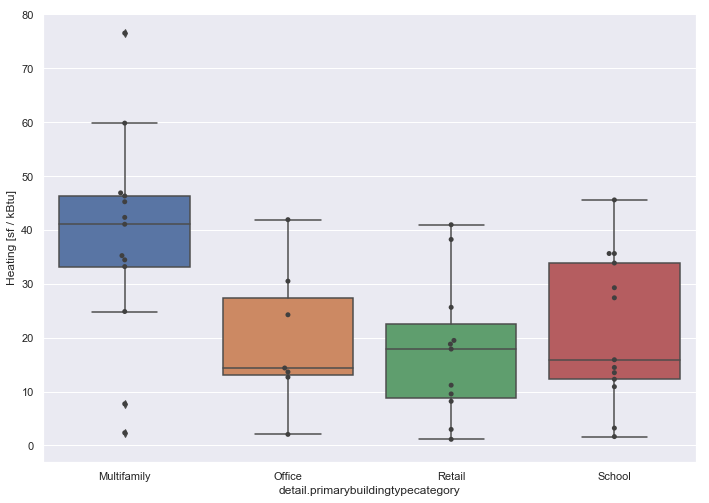

In [35]:
CAPACITIES_plot=CAPACITIES.drop(coolingEst_droplist)

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y='Heating [sf / kBtu]', data=CAPACITIES_plot, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y='Heating [sf / kBtu]', data=CAPACITIES_plot)

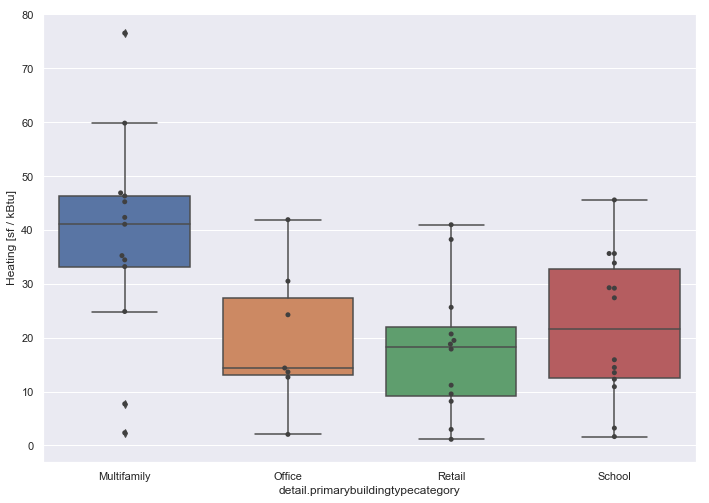

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y='Heating [sf / kBtu]', data=CAPACITIES, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y='Heating [sf / kBtu]', data=CAPACITIES)

## Cooling Capacities - Equipment Summation

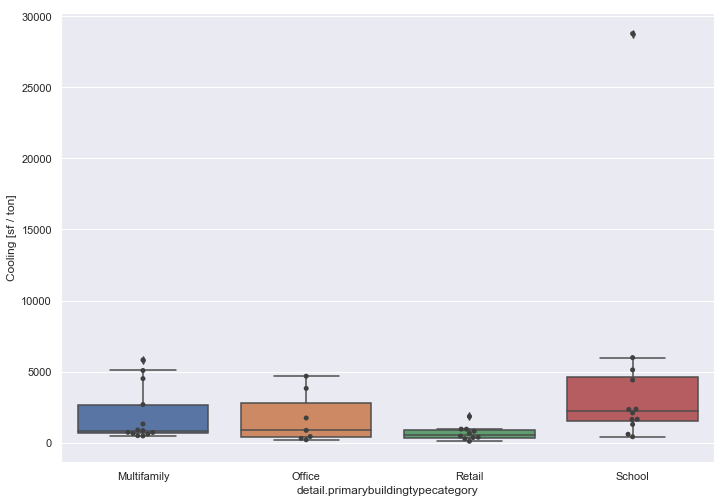

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="detail.primarybuildingtypecategory", y='Cooling [sf / ton]', data=CAPACITIES_plot, color=".25")
ax = sns.boxplot(x="detail.primarybuildingtypecategory", y='Cooling [sf / ton]', data=CAPACITIES_plot)

# LOAD V. CAPACITY COMPARISON

In [38]:
df = pd.DataFrame()

In [39]:
## General Data
df['siteid'] = CAPACITIES['siteid']
df['Building Type'] = CAPACITIES['detail.primarybuildingtypecategory']

## Load Data
cool = []
heat = []

for i in range(0, len(df)):
    cool.append(1/((1 / ENV_GAIN['Cooling [sf / ton]'][i]) + 
                (1 / OA_LOADS['OA Cooling [sf / ton]'][df['siteid'][i]])))
    
    heat.append(1/((1 / ENV_LOSS['Heating [sf / kBtu]'][i]) + 
                (1 / OA_LOADS['OA Heating [sf / kBtu]'][df['siteid'][i]])))




df['Cooling Estimated Load [sf / ton]'] = cool
df['Heating Estimated Load [sf / kBtu]'] = heat

#Equipment Capacity Data
df['Cooling Equipment Capacity [sf / ton]'] = CAPACITIES['Cooling [sf / ton]']
df['Heating Equipment Capacity [sf / kBtu]'] = CAPACITIES['Heating [sf / kBtu]']

folder = 'RESULTS\\'
name = 'COMPILED.csv'
df.to_csv(path + folder + name)

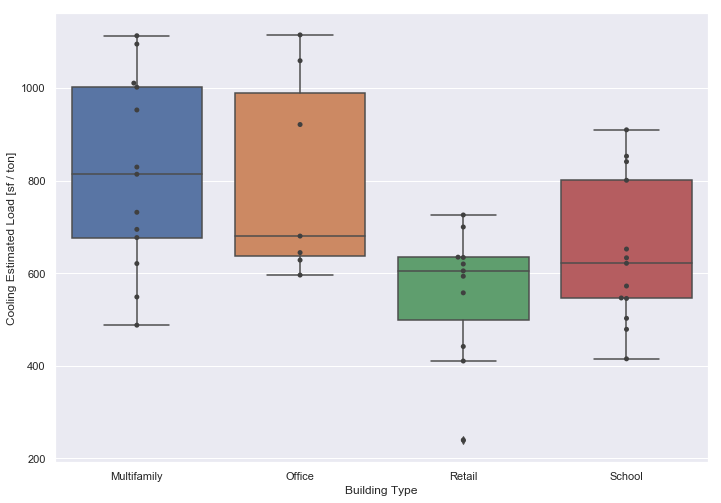

In [40]:
df_plot = df.drop(coolingEst_droplist)
df_plot

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="Building Type", y="Cooling Estimated Load [sf / ton]", data=df_plot, color=".25")
ax = sns.boxplot(x="Building Type", y="Cooling Estimated Load [sf / ton]", data=df_plot)

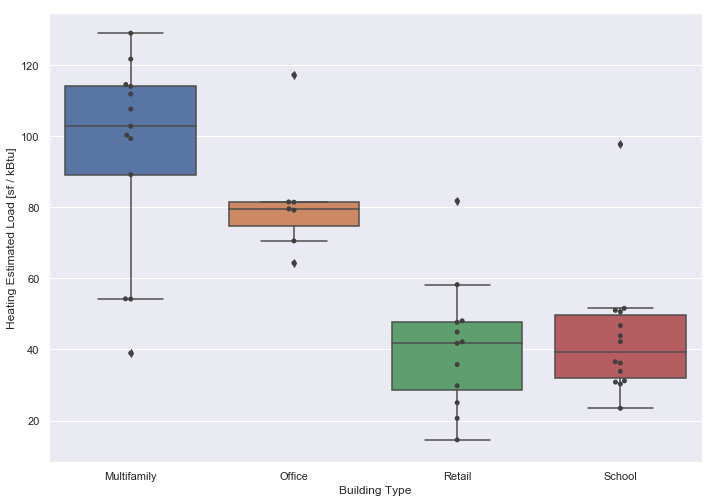

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.swarmplot(x="Building Type", y="Heating Estimated Load [sf / kBtu]", data=df, color=".25")
ax = sns.boxplot(x="Building Type", y="Heating Estimated Load [sf / kBtu]", data=df)

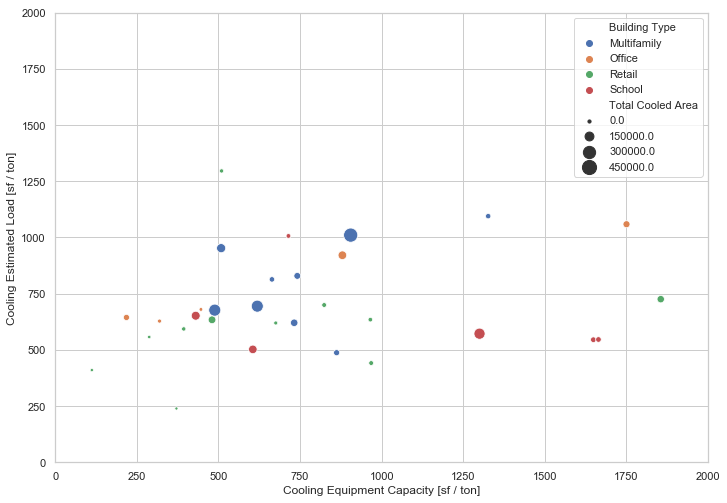

In [42]:
with sns.axes_style("whitegrid"):

    # control x and y limits
    plt.ylim(0, 2000)
    plt.xlim(0, 2000)
    #plt.plot([0, 5000], [0, 5000], sns.xkcd_rgb["pale red"], lw=0.5)
    
    #cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    ax = sns.scatterplot(x="Cooling Equipment Capacity [sf / ton]", y="Cooling Estimated Load [sf / ton]",
                         hue="Building Type", size=cooled_area,
                         sizes=(10, 200),
                         data=df)

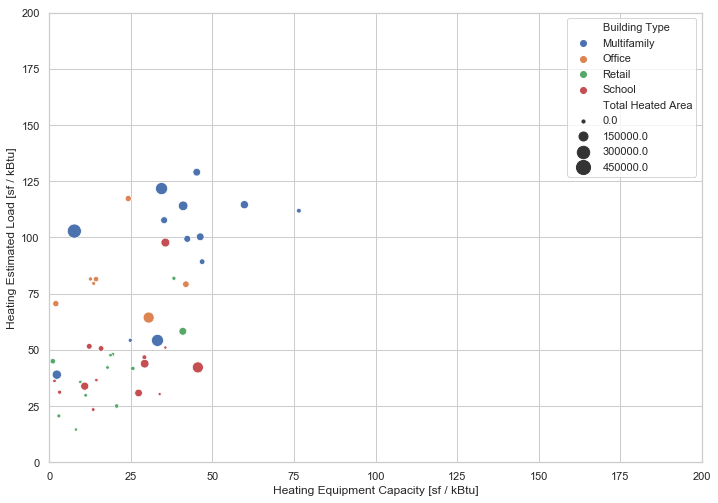

In [43]:
with sns.axes_style("whitegrid"):
    
    # control x and y limits
    plt.ylim(0, 200)
    plt.xlim(0, 200)
    #plt.plot([0, 200], [0, 200], sns.xkcd_rgb["pale red"], lw=0.5)
    
    #cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    ax = sns.scatterplot(x="Heating Equipment Capacity [sf / kBtu]", y="Heating Estimated Load [sf / kBtu]",
                         hue="Building Type", size=heated_area,
                         sizes=(10, 200),
                         data=df)
    
plt.show(ax)

## Heating Comparison 

In [48]:
df_cool = df.drop(coolingEst_droplist)

In [49]:
df_long_heating = pd.melt(df, id_vars=["Building Type"],
                          value_vars=["Heating Estimated Load [sf / kBtu]",
                                      "Heating Equipment Capacity [sf / kBtu]"])

df_long_cooling = pd.melt(df_cool, id_vars=["Building Type"],
                          value_vars=["Cooling Estimated Load [sf / ton]",
                                      "Cooling Equipment Capacity [sf / ton]"])

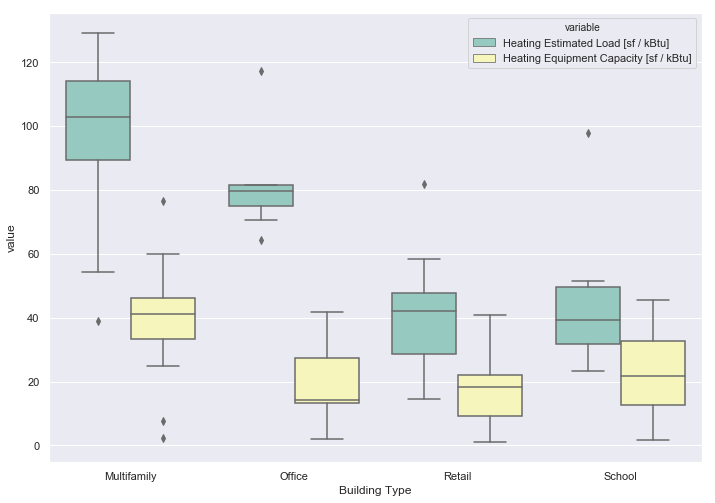

In [50]:
ax = sns.boxplot(x="Building Type", y="value", hue="variable", data=df_long_heating, palette="Set3")

## Cooling Comparison

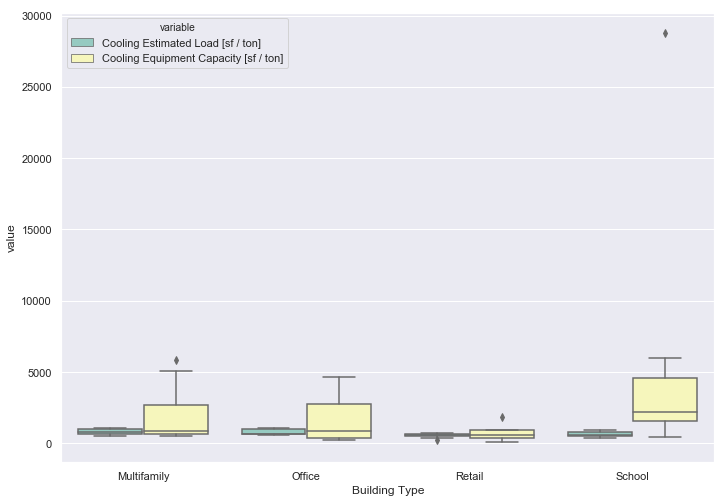

In [51]:
ax = sns.boxplot(x="Building Type", y="value", hue="variable", data=df_long_cooling, palette="Set3")